# PART 1

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:00<00:00, 117839442.83it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8611218.88it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61601852.30it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6049951.52it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


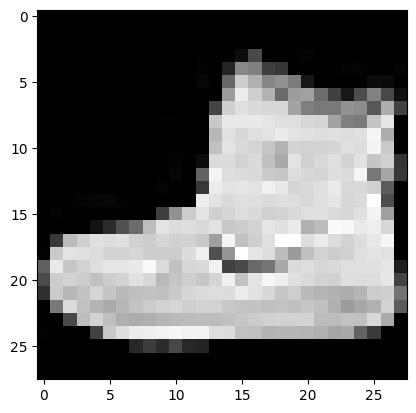

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([4, 4, 6, 6, 9, 5, 1, 6, 6, 5, 3, 5, 7, 2, 5, 8, 1, 8, 0, 2, 7, 3, 0, 0,
        5, 6, 3, 5, 2, 2, 0, 8, 6, 0, 3, 5, 7, 8, 4, 1, 0, 4, 2, 3, 8, 0, 8, 2,
        4, 8, 2, 9, 7, 2, 8, 4, 8, 2, 9, 3, 1, 0, 3, 9, 9, 0, 1, 0, 8, 1, 2, 2,
        7, 5, 5, 3, 6, 0, 9, 2, 9, 3, 9, 4, 1, 8, 6, 1, 9, 0, 4, 9, 4, 8, 9, 9,
        4, 0, 9, 4])


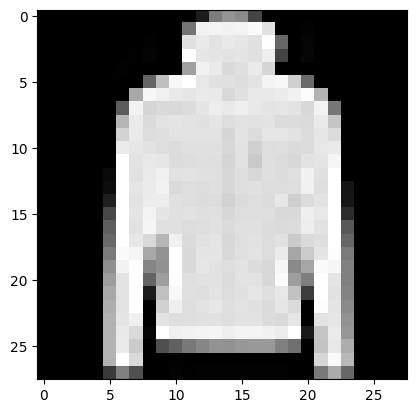

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

# Discriminator


In [8]:
image_size = 784
hidden_size = 256

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

# Generator

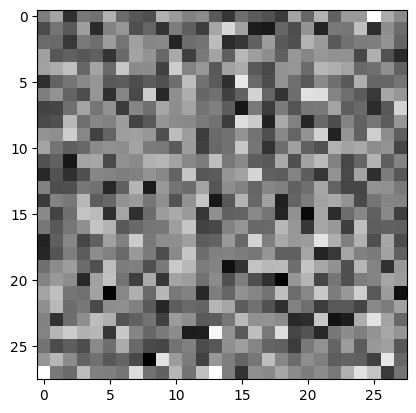

In [9]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

plt.imshow(gen_imgs[0], cmap='gray');



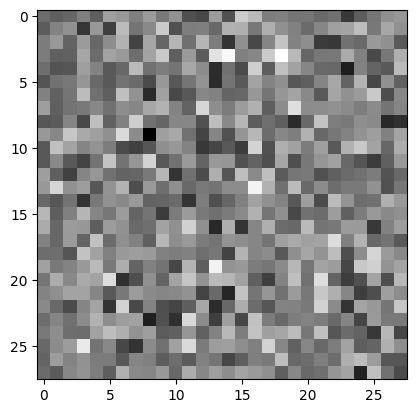

In [ ]:
plt.imshow(gen_imgs[1], cmap='gray');

In [ ]:
G.to(device);

# Discriminator Training

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

# Generator Training

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Model Training

In [17]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

sample_dir = '/content/drive/MyDrive/DL_HW5/sample_images'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


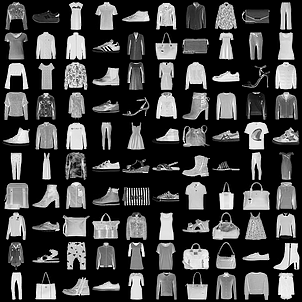

In [18]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


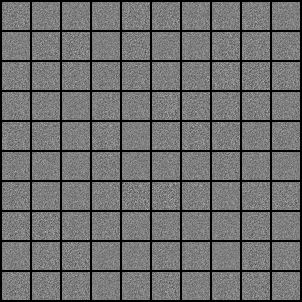

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0760, g_loss: 4.1118, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [400/600], d_loss: 0.1404, g_loss: 5.4260, D(x): 0.96, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0402, g_loss: 5.0548, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1191, g_loss: 4.8465, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0692, g_loss: 4.2582, D(x): 0.98, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.0368, g_loss: 5.5098, D(x): 1.00, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0706, g_loss: 5.6601, D(x): 0.99, D(G(z)): 0.06
Epoch [2/300], Step [400/600], d_loss: 0.0389, g_loss: 7.2658, D(x): 0.98, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0378, g_loss: 8.0143, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0346, g_loss: 5.7394, D(x): 0.99, D(G(z)): 0.01
Epoch [3/300], Step [400/6

# Save the model

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory to save the model
model_dir = '/content/drive/MyDrive/DL_HW5/saved_models'

# Check if the directory exists, if not, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model checkpoints
torch.save(G.state_dict(), os.path.join(model_dir, 'G.ckpt'))
torch.save(D.state_dict(), os.path.join(model_dir, 'D.ckpt'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


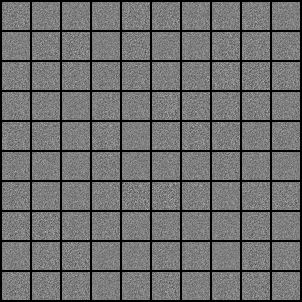

In [ ]:
Image('/content/drive/MyDrive/DL_HW5/sample_images/fake_images-0000.png')

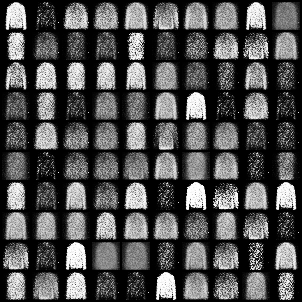

In [ ]:
Image('/content/drive/MyDrive/DL_HW5/sample_images/fake_images-0010.png')

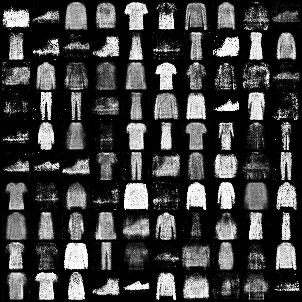

In [ ]:
Image('/content/drive/MyDrive/DL_HW5/sample_images/fake_images-0100.png')

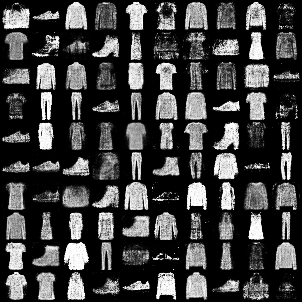

In [ ]:
Image('/content/drive/MyDrive/DL_HW5/sample_images/fake_images-0300.png')

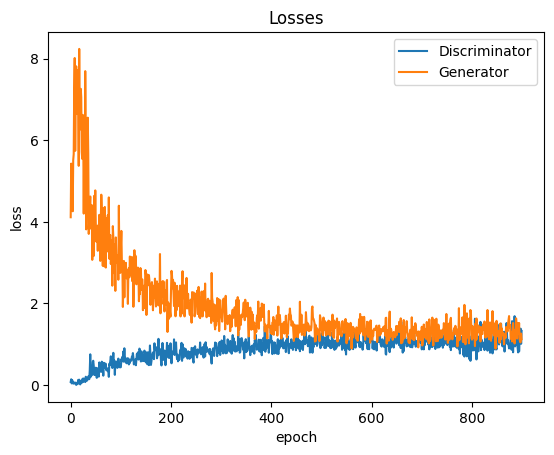

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

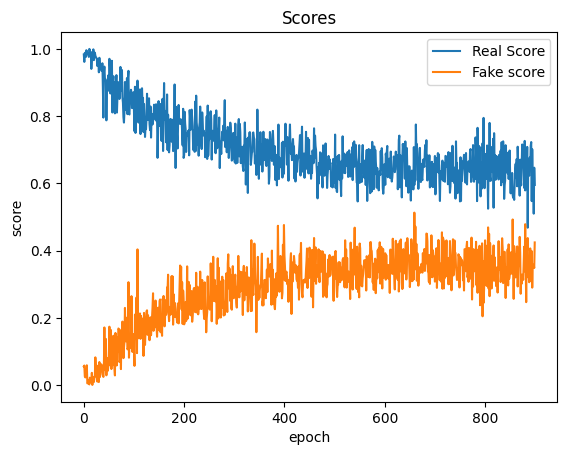

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

# Reloading the saved model

In [ ]:
import torch
import os

# Check if CUDA is available
if torch.cuda.is_available():
    map_location = torch.device('cuda')
else:
    map_location = torch.device('cpu')

# Path to your model directory
model_dir = '/content/drive/MyDrive/DL_HW5/saved_models'

# Load the model with map_location specified
G.load_state_dict(torch.load(os.path.join(model_dir, 'G.ckpt'), map_location=map_location))
D.load_state_dict(torch.load(os.path.join(model_dir, 'D.ckpt'), map_location=map_location))


<All keys matched successfully>

In [ ]:
def save_fake_images_retrained(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images_retrained-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [ ]:
additional_epochs = 300
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

for epoch in range(additional_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss_1, real_score_1, fake_score_1 = train_discriminator(images)
        g_loss_1, fake_images_1 = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss_1.item())
            g_losses.append(g_loss_1.item())
            real_scores.append(real_score_1.mean().item())
            fake_scores.append(fake_score_1.mean().item())
            print('additional_epochs [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(additional_epochs, num_epochs, i+1, total_step, d_loss_1.item(), g_loss_1.item(),
                          real_score_1.mean().item(), fake_score_1.mean().item()))

    # Sample and save images
    save_fake_images_retrained(epoch+1)



additional_epochs [300/300], Step [200/600], d_loss: 1.4190, g_loss: 1.0704, D(x): 0.65, D(G(z)): 0.51
additional_epochs [300/300], Step [400/600], d_loss: 0.7889, g_loss: 1.2980, D(x): 0.70, D(G(z)): 0.26
additional_epochs [300/300], Step [600/600], d_loss: 1.0165, g_loss: 1.2534, D(x): 0.64, D(G(z)): 0.33
Saving fake_images_retrained-0001.png
additional_epochs [300/300], Step [200/600], d_loss: 1.0110, g_loss: 1.3411, D(x): 0.66, D(G(z)): 0.37
additional_epochs [300/300], Step [400/600], d_loss: 1.1258, g_loss: 1.1391, D(x): 0.65, D(G(z)): 0.39
additional_epochs [300/300], Step [600/600], d_loss: 1.1487, g_loss: 1.2475, D(x): 0.68, D(G(z)): 0.44
Saving fake_images_retrained-0002.png
additional_epochs [300/300], Step [200/600], d_loss: 1.2456, g_loss: 1.3753, D(x): 0.60, D(G(z)): 0.36
additional_epochs [300/300], Step [400/600], d_loss: 1.0462, g_loss: 1.8807, D(x): 0.74, D(G(z)): 0.37
additional_epochs [300/300], Step [600/600], d_loss: 1.0332, g_loss: 1.3594, D(x): 0.60, D(G(z)): 0.

# Save the Model without Checkpoint

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the directory to save the model
model_dir = '/content/drive/MyDrive/DL_HW5/saved_models'

# Check if the directory exists, if not, create it
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the model checkpoints
torch.save(G.state_dict(), os.path.join(model_dir, 'generator_1.pth'))
torch.save(D.state_dict(), os.path.join(model_dir, 'discriminator_1.pth'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Model without checkpoint

In [ ]:
# Load the saved model weights
G.load_state_dict(torch.load(os.path.join(model_dir, 'generator_1.pth')))
D.load_state_dict(torch.load(os.path.join(model_dir, 'discriminator_1.pth')))

<All keys matched successfully>

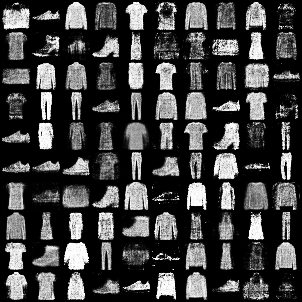

In [5]:
from IPython.display import Image

# Path to the image file
image_path = '/content/drive/MyDrive/DL_HW5/sample_images/fake_images_retrained-0001.png'

# Display the image
Image(image_path)


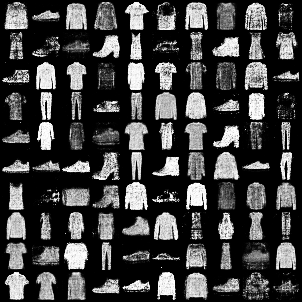

In [7]:
from IPython.display import Image

# Path to the image file
image_path = '/content/drive/MyDrive/DL_HW5/sample_images/fake_images_retrained-0200.png'

# Display the image
Image(image_path)

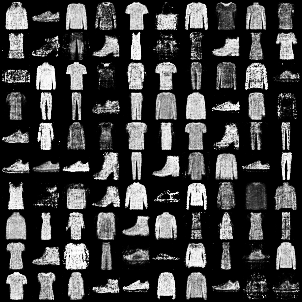

In [8]:
from IPython.display import Image

# Path to the image file
image_path = '/content/drive/MyDrive/DL_HW5/sample_images/fake_images_retrained-0300.png'

# Display the image
Image(image_path)

# PART 2: Least Square GAN

In [24]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

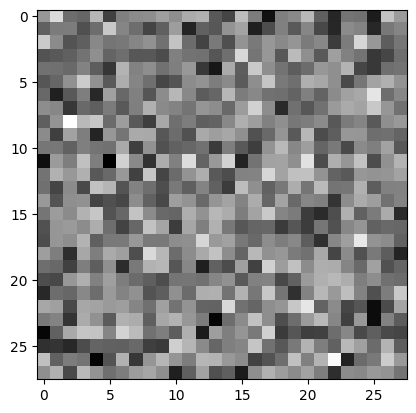

In [25]:
image_size = 784
hidden_size = 256

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

G.to(device);

plt.imshow(gen_imgs[0], cmap='gray');




Discrminator training using LSGAN

In [26]:
def train_discriminator(images):
    # Create the labels
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    real_outputs = D(images)
    d_loss_real = torch.mean((real_outputs - 1) ** 2)  # LSGAN loss for real images
    real_score = real_outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_outputs = D(fake_images.detach())  # Detach to avoid computing gradients for G
    d_loss_fake = torch.mean(fake_outputs ** 2)  # LSGAN loss for fake images
    fake_score = fake_outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Backpropagation
    d_loss.backward()

    # Update discriminator parameters
    d_optimizer.step()

    return d_loss, real_score, fake_score


In [27]:
def train_generator():
    # Generate fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)

    # LSGAN loss for generator
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = torch.mean((D(fake_images) - labels) ** 2)

    # Reset gradients
    reset_grad()

    # Backpropagation
    g_loss.backward()

    # Update generator parameters
    g_optimizer.step()

    return g_loss, fake_images


In [28]:
def save_ls_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'lsgan_fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)


In [37]:
%%time

from IPython.display import Image
from torchvision.utils import save_image
import os

sample_vectors = torch.randn(batch_size, latent_size).to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_ls_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0138, g_loss: 0.9970, D(x): 0.98, D(G(z)): 0.00
Epoch [0/300], Step [400/600], d_loss: 0.0380, g_loss: 0.9717, D(x): 0.95, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0080, g_loss: 0.9720, D(x): 0.99, D(G(z)): 0.03
Saving lsgan_fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0508, g_loss: 0.9815, D(x): 0.96, D(G(z)): 0.07
Epoch [1/300], Step [400/600], d_loss: 0.0248, g_loss: 0.9729, D(x): 0.99, D(G(z)): 0.07
Epoch [1/300], Step [600/600], d_loss: 0.0550, g_loss: 0.9733, D(x): 0.97, D(G(z)): 0.11
Saving lsgan_fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0201, g_loss: 0.9938, D(x): 0.97, D(G(z)): 0.00
Epoch [2/300], Step [400/600], d_loss: 0.0329, g_loss: 0.9812, D(x): 0.94, D(G(z)): 0.04
Epoch [2/300], Step [600/600], d_loss: 0.0609, g_loss: 0.9892, D(x): 0.92, D(G(z)): 0.01
Saving lsgan_fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0174, g_loss: 0.9634, D(x): 0.98, D(G(z)): 0.04
Epoch [3

In [22]:
# LSGAN using MSE


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latent_size = 64
image_size = 1225
hidden_size = 256

# Generator model
class Generator(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),  # Output size matches discriminator input size
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)



# Initialize models
G = Generator(latent_size, hidden_size, image_size).to(device)
D = Discriminator(image_size, hidden_size).to(device)

# Loss function for LSGAN
criterion = nn.MSELoss()

# Optimizers
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

d_losses = []
g_losses = []

# Training loop
num_epochs = 100
batch_size = 64
total_step = len(data_loader)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Reshape images and move to device
        images = images.reshape(batch_size, -1).to(device)

        # Train discriminator with real images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_optimizer.zero_grad()
        real_output = D(images)
        d_loss_real = criterion(real_output, real_labels)

        # Train discriminator with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        fake_output = D(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        fake_output = D(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item()))

    # Save generated images
    with torch.no_grad():
        z = torch.randn(16, latent_size).to(device)
        fake_images = G(z).cpu().view(-1, 1, 28, 28)
        save_image(fake_images, 'lsgan_generated_images-{}.png'.format(epoch+1), nrow=4, normalize=True)



Epoch [0/100], Step [200/600], d_loss: 0.0152, g_loss: 0.9435
Epoch [0/100], Step [400/600], d_loss: 0.0023, g_loss: 0.9580
Epoch [0/100], Step [600/600], d_loss: 0.0011, g_loss: 0.9718
Epoch [1/100], Step [200/600], d_loss: 0.0004, g_loss: 0.9817
Epoch [1/100], Step [400/600], d_loss: 0.0001, g_loss: 0.9891
Epoch [1/100], Step [600/600], d_loss: 0.0034, g_loss: 0.9522
Epoch [2/100], Step [200/600], d_loss: 0.0001, g_loss: 0.9926
Epoch [2/100], Step [400/600], d_loss: 0.0005, g_loss: 0.9776
Epoch [2/100], Step [600/600], d_loss: 0.0000, g_loss: 0.9978
Epoch [3/100], Step [200/600], d_loss: 0.0085, g_loss: 0.9363
Epoch [3/100], Step [400/600], d_loss: 0.0012, g_loss: 0.9700
Epoch [3/100], Step [600/600], d_loss: 0.0002, g_loss: 0.9916
Epoch [4/100], Step [200/600], d_loss: 0.0002, g_loss: 0.9867
Epoch [4/100], Step [400/600], d_loss: 0.0001, g_loss: 0.9969
Epoch [4/100], Step [600/600], d_loss: 0.0153, g_loss: 0.9952
Epoch [5/100], Step [200/600], d_loss: 0.0002, g_loss: 0.9984
Epoch [5

REESULT and DISCUSSIONS

1. The initial GAN model was trained for 300 epochs, resulting in improved generated images that, while not indistinguishable from real images, showed noticeable enhancement.
2. Subsequent attempts to retrain the GAN for an additional 300 epochs did not yield significant improvement, with the generated images remaining similar to those produced by the original model.
3. On the other hand, implementing the LSGAN architecture and training it for 100 epochs led to some improvement in convergence compared to the standard GAN, resulting in better quality fake images.
4. Continuing the training of the LSGAN for an extended period of 300 epochs further enhanced its convergence, producing even better fake images with improved realism.
5. Overall, the LSGAN demonstrated superior performance generating better quality image and convergence compared to the standard GAN, particularly evident after an extended training period, showcasing its effectiveness in generating high-quality synthetic images.